# MODEL SETUP

In [128]:
import os
import sys
import json
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import tensorflow as tf
import pandas as pd
import seaborn as sns

# Control font size of all seaborn images. Increased for the sake of readability
sns.set()
sns.set_context("paper",font_scale=2)

import ast

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

#Import adaptions
from fashion_config import FashionConfig
from fashion_dataset import FashionDataset

%matplotlib inline

# Hide some tensorflaw warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [2]:
""" Load config """ 
config = FashionConfig()
#config.display()

In [3]:
""" Prepare dataset """ 
dataset_train = FashionDataset()
dataset_train.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "train")
dataset_train.prepare()

dataset_val = FashionDataset()
dataset_val.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "val")
dataset_val.prepare()


In [4]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [5]:
# Load trained weights
model_path = "../logs/final_logs/logs_mask_rcnn_fashion_0045.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../logs/final_logs/logs_mask_rcnn_fashion_0045.h5


In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# EVALUATIONS


## Visual comparison between ground truth and model

Image #15899
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (26,)                 min:    0.00000  max: 15899.00000  float64
gt_class_id              shape: (2,)                  min:    2.00000  max:    7.00000  uint8
gt_bbox                  shape: (2, 4)                min:  204.00000  max:  567.00000  int32
gt_mask                  shape: (640, 640, 2)         min:    0.00000  max:    1.00000  uint8
gt_landmark              shape: (640, 640, 2)         min:    0.00000  max:    2.00000  float64


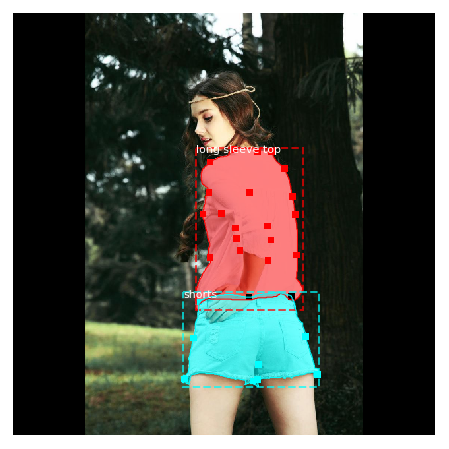

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


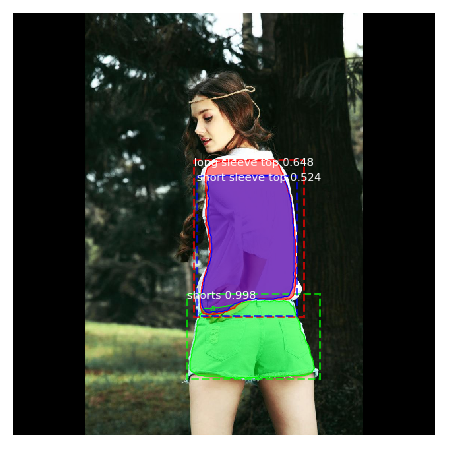

In [7]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

#Test on specific image
#image_id = 17803
#image_id = 7818
print("Image #{}".format(image_id))

image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_landmark =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_landmark", gt_landmark)

visualize.display_instances(image, gt_bbox, gt_mask, gt_landmark, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

results = model.detect([image], verbose=2)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['landmarks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Precision-recall curve
* The X-axis is recall: Recall is High if the amount of False Negatives is Low
* The Y-axis is precision: Precision is High if the amount of False Positives is low.


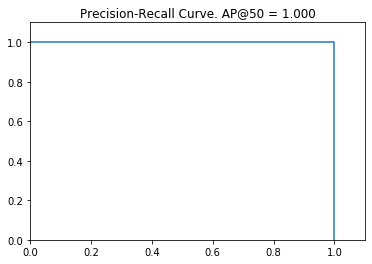

In [8]:
# Draw precision-recall curve based on what is returned in the image
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

## Heatmap of predictions and ground truth (Still in beta)

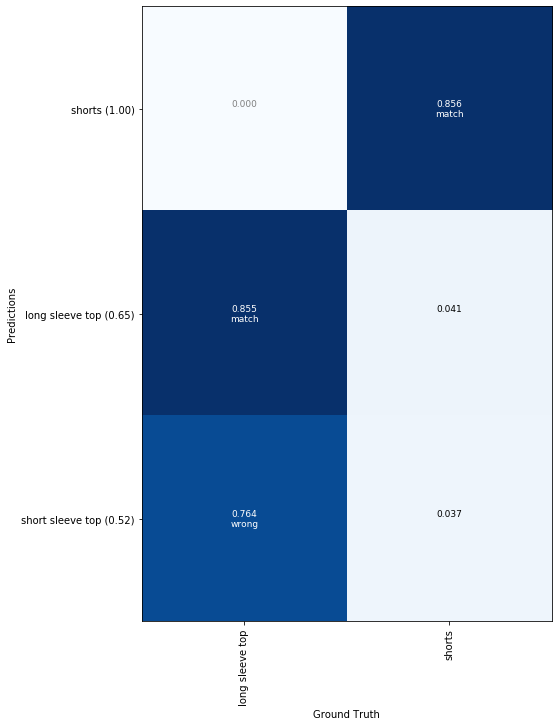

In [9]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

## Compare the generated masks
Useful to see what the network sees when there is overlap

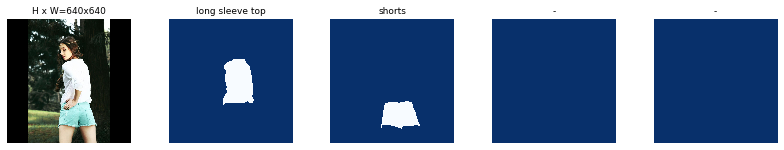

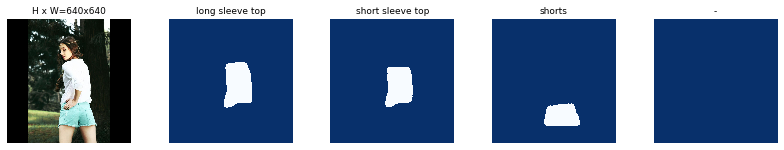

In [10]:
visualize.display_top_masks(image, gt_mask, gt_class_id, 
                            dataset_val.class_names)
visualize.display_top_masks(image, r['masks'], r['class_ids'], 
                            dataset_val.class_names)

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [11]:
#Check the names of all layers
for layer in model.keras_model.layers:
    print(layer.name)

input_image
zero_padding2d_1
conv1
bn_conv1
activation_1
max_pooling2d_1
res2a_branch2a
bn2a_branch2a
activation_2
res2a_branch2b
bn2a_branch2b
activation_3
res2a_branch2c
res2a_branch1
bn2a_branch2c
bn2a_branch1
add_1
res2a_out
res2b_branch2a
bn2b_branch2a
activation_4
res2b_branch2b
bn2b_branch2b
activation_5
res2b_branch2c
bn2b_branch2c
add_2
res2b_out
res2c_branch2a
bn2c_branch2a
activation_6
res2c_branch2b
bn2c_branch2b
activation_7
res2c_branch2c
bn2c_branch2c
add_3
res2c_out
res3a_branch2a
bn3a_branch2a
activation_8
res3a_branch2b
bn3a_branch2b
activation_9
res3a_branch2c
res3a_branch1
bn3a_branch2c
bn3a_branch1
add_4
res3a_out
res3b_branch2a
bn3b_branch2a
activation_10
res3b_branch2b
bn3b_branch2b
activation_11
res3b_branch2c
bn3b_branch2c
add_5
res3b_out
res3c_branch2a
bn3c_branch2a
activation_12
res3c_branch2b
bn3c_branch2b
activation_13
res3c_branch2c
bn3c_branch2c
add_6
res3c_out
res3d_branch2a
bn3d_branch2a
activation_14
res3d_branch2b
bn3d_branch2b
activation_15
res3d_bra

res3a_out                shape: (1, 80, 80, 512)      min:    0.00000  max:   16.61452  float32
input_image              shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10001  float32
rpn_bbox                 shape: (1, 102300, 4)        min:   -9.04839  max:   73.27912  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


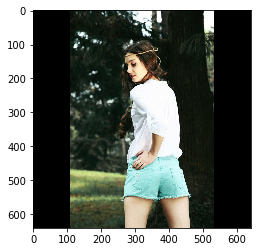

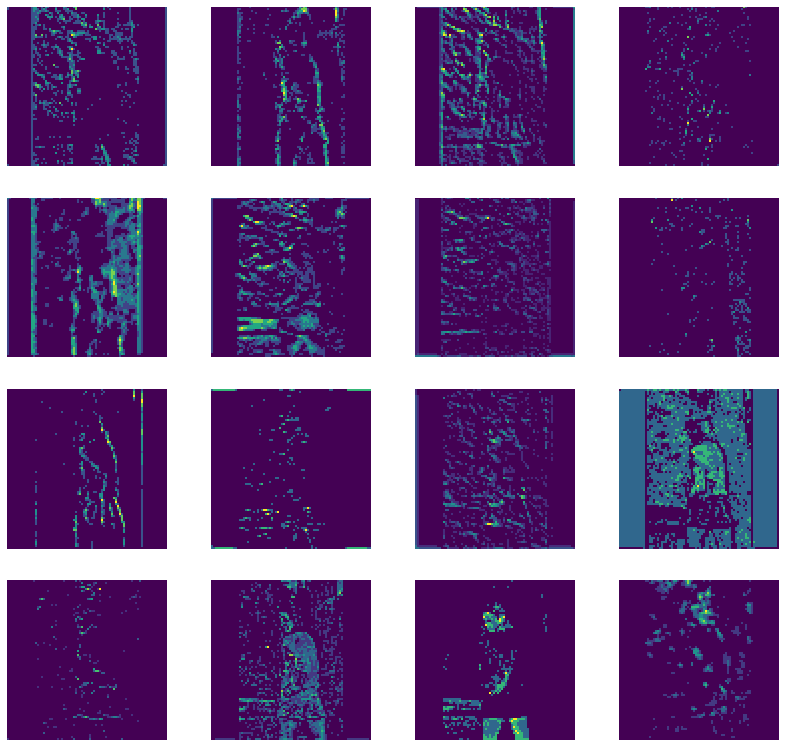

In [12]:
# Get activations of a few sample layers

# Select layer to visualize. Most play nicely with the backbone feature mapping, but not all.
layer_name = 'res3a_out'

activations = model.run_graph([image], [
    (layer_name,           model.keras_model.get_layer(layer_name).output),
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

# Show input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0], config))

# Show Backbone feature map
display_images(np.transpose(activations[layer_name][0,:,:,:16], [2, 0, 1]))

# Activation differences

## Extract samples to compare

In [27]:
# Get differences in activations
# Select layer to visualize.
NUM_PICS_PER_CLOTHING = 2
dataset = dataset_val
layer_names = ['mrcnn_class_conv1', 'mrcnn_class_conv2', 'mrcnn_class_logits']

choices = dict()
for info in dataset.class_info:
    if info['id'] != 0:
        choices[info['id']] = []
        
for image_id in dataset.image_ids:
    info = dataset.image_info[image_id]
    if len(info['clothes']) > 1: continue # don't use image with multiple cloths in
    gt_class_id = info['clothes'][0]['category_id']
    if len(choices[gt_class_id]) < NUM_PICS_PER_CLOTHING:
        image, _, _, _, _, _ = modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)
        choices[gt_class_id].append(image)
    if len([True for x, v in choices.items() if len(v) == NUM_PICS_PER_CLOTHING]) == 13:
        break

for k,v in choices.items():
    print("Class id %d has %d images" %(k, len(v)))

Class id 1 has 2 images
Class id 2 has 2 images
Class id 3 has 2 images
Class id 4 has 2 images
Class id 5 has 2 images
Class id 6 has 2 images
Class id 7 has 2 images
Class id 8 has 2 images
Class id 9 has 2 images
Class id 10 has 2 images
Class id 11 has 2 images
Class id 12 has 2 images
Class id 13 has 2 images


## Compare samples
### Compare cross clothing activations

In [28]:
# get activations for specified layers
activations = dict()
for k,v in choices.items():
    if len(v) == 0: continue
    activations[k] = []
    for image in v:
        activations[k].append(model.run_graph([image], [(layer_name,model.keras_model.get_layer(layer_name).output) for layer_name in layer_names]))

mrcnn_class_conv1        shape: (1, 1000, 1, 1, 1024)  min:  -16.78832  max:   16.99327  float32
mrcnn_class_conv2        shape: (1, 1000, 1, 1, 1024)  min:   -7.62526  max:    8.81644  float32
mrcnn_class_logits       shape: (1, 1000, 14)         min:   -6.75706  max:   40.94451  float32
mrcnn_class_conv1        shape: (1, 1000, 1, 1, 1024)  min:  -17.04112  max:   17.52983  float32
mrcnn_class_conv2        shape: (1, 1000, 1, 1, 1024)  min:   -7.61872  max:    8.81272  float32
mrcnn_class_logits       shape: (1, 1000, 14)         min:   -7.10243  max:   40.85958  float32
mrcnn_class_conv1        shape: (1, 1000, 1, 1, 1024)  min:  -21.12235  max:   19.87918  float32
mrcnn_class_conv2        shape: (1, 1000, 1, 1, 1024)  min:   -7.61951  max:    8.77369  float32
mrcnn_class_logits       shape: (1, 1000, 14)         min:   -6.87796  max:   40.94162  float32
mrcnn_class_conv1        shape: (1, 1000, 1, 1, 1024)  min:  -13.30320  max:   13.82550  float32
mrcnn_class_conv2        shape: (

In [29]:
differences = np.zeros((len(layer_names), 13, 13))
print(differences.shape)
for class_id1, a in activations.items():
    activation_per_layer1 = a[0] # only use first image for comparison
    for class_id2, b in activations.items():
        activation_per_layer2 = b[0] # only use first image for comparison
        if class_id2 > class_id1:
            for layer_idx, layer in enumerate(activation_per_layer1):
                activation1 = activation_per_layer1[layer]
                activation2 = activation_per_layer2[layer]
                print("Comparing class ids %d and %d for layer %s" % (class_id1, class_id2, layer))
                abs_diff = np.abs((activation1 - activation2))
                differences[layer_idx][class_id1-1][class_id2-1] = np.sum(abs_diff)

for i in range(len(layer_names)):
    differences[i] = differences[i] / np.max(differences[i])                

(3, 13, 13)
Comparing class ids 1 and 2 for layer mrcnn_class_conv1
Comparing class ids 1 and 2 for layer mrcnn_class_conv2
Comparing class ids 1 and 2 for layer mrcnn_class_logits
Comparing class ids 1 and 3 for layer mrcnn_class_conv1
Comparing class ids 1 and 3 for layer mrcnn_class_conv2
Comparing class ids 1 and 3 for layer mrcnn_class_logits
Comparing class ids 1 and 4 for layer mrcnn_class_conv1
Comparing class ids 1 and 4 for layer mrcnn_class_conv2
Comparing class ids 1 and 4 for layer mrcnn_class_logits
Comparing class ids 1 and 5 for layer mrcnn_class_conv1
Comparing class ids 1 and 5 for layer mrcnn_class_conv2
Comparing class ids 1 and 5 for layer mrcnn_class_logits
Comparing class ids 1 and 6 for layer mrcnn_class_conv1
Comparing class ids 1 and 6 for layer mrcnn_class_conv2
Comparing class ids 1 and 6 for layer mrcnn_class_logits
Comparing class ids 1 and 7 for layer mrcnn_class_conv1
Comparing class ids 1 and 7 for layer mrcnn_class_conv2
Comparing class ids 1 and 7 for

Comparing class ids 10 and 11 for layer mrcnn_class_logits
Comparing class ids 10 and 12 for layer mrcnn_class_conv1
Comparing class ids 10 and 12 for layer mrcnn_class_conv2
Comparing class ids 10 and 12 for layer mrcnn_class_logits
Comparing class ids 10 and 13 for layer mrcnn_class_conv1
Comparing class ids 10 and 13 for layer mrcnn_class_conv2
Comparing class ids 10 and 13 for layer mrcnn_class_logits
Comparing class ids 11 and 12 for layer mrcnn_class_conv1
Comparing class ids 11 and 12 for layer mrcnn_class_conv2
Comparing class ids 11 and 12 for layer mrcnn_class_logits
Comparing class ids 11 and 13 for layer mrcnn_class_conv1
Comparing class ids 11 and 13 for layer mrcnn_class_conv2
Comparing class ids 11 and 13 for layer mrcnn_class_logits
Comparing class ids 12 and 13 for layer mrcnn_class_conv1
Comparing class ids 12 and 13 for layer mrcnn_class_conv2
Comparing class ids 12 and 13 for layer mrcnn_class_logits


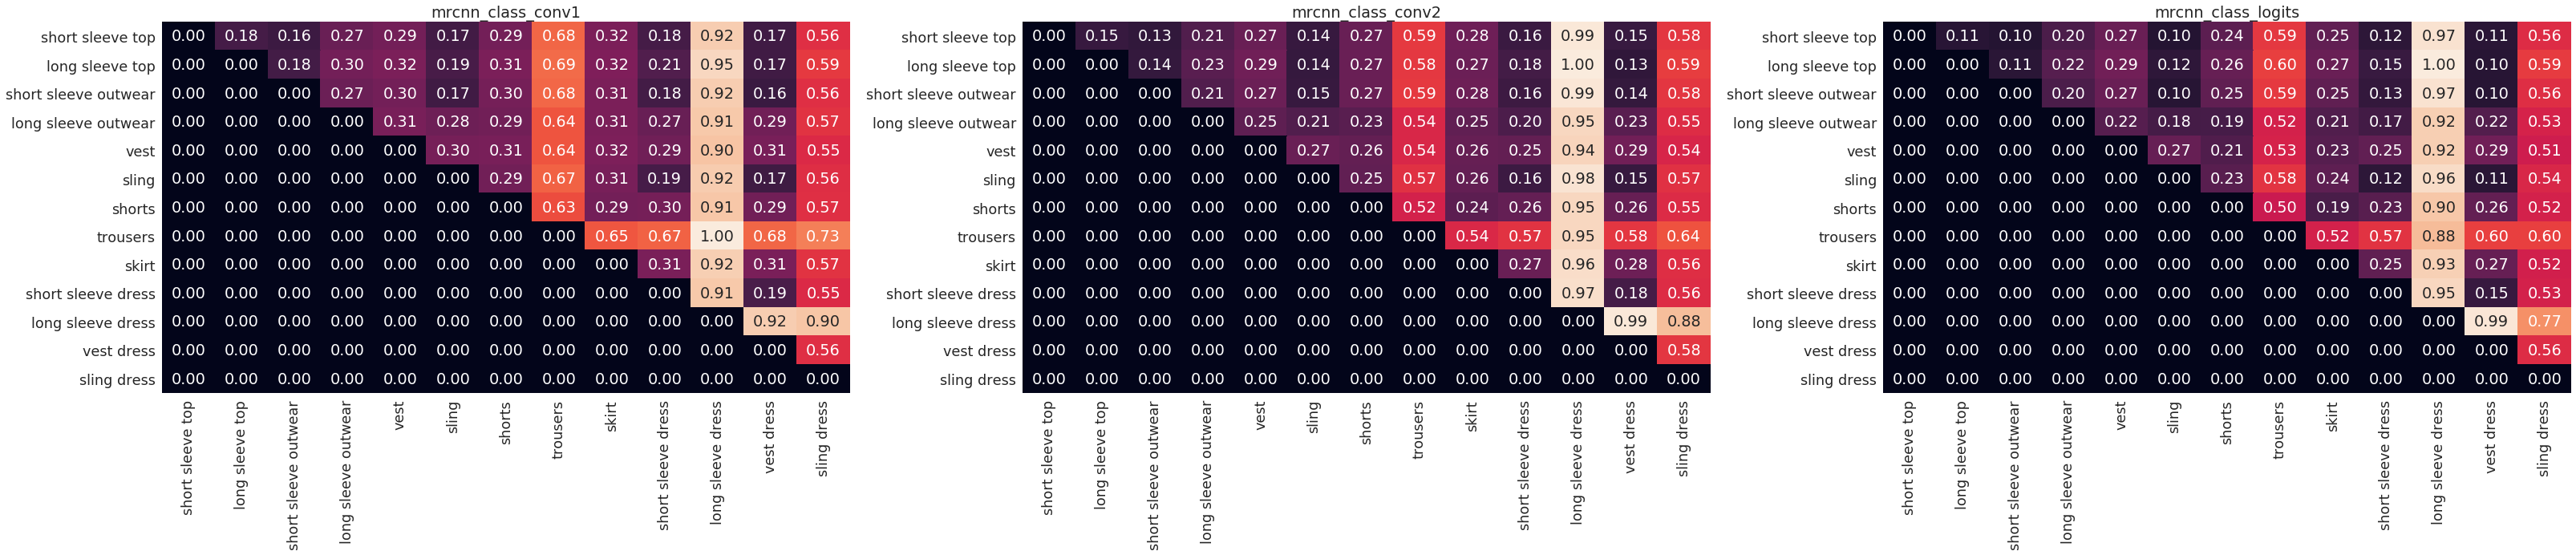

In [149]:
#Visualize it
x = [info['name'] for info in dataset.class_info if info['name'] != 'BG']
# create an index for each tick position
xi = list(range(len(x)))

fig, axs = plt.subplots(1, 3, figsize=(3*15, 10))

for i in range(1, len(layer_names)+1):
    ax = axs[i-1]
    ax.set_title(layer_names[i-1])
    df = pd.DataFrame(data=differences[i-1])
    df.columns = x
    df.index = df.columns.values
    sns.heatmap(df, annot=True, ax = ax, fmt='.2f', cbar=False)
plt.tight_layout()
plt.show()

### Compare two images of same clothing 

In [32]:
if NUM_PICS_PER_CLOTHING > 1:
    differences_same = np.zeros((len(layer_names), 1, 13))
    print(differences_same.shape)
    for class_id, images in activations.items():
        for layer_idx, layer in enumerate(images[0]):
            activation1 = images[0][layer]
            activation2 = images[1][layer]
            print("Compareing 2 images of class id %d for layer %s" % (class_id, layer))
            abs_diff = np.abs((activation1 - activation2))
            differences_same[layer_idx][0][class_id-1] = np.sum(abs_diff)

    for i in range(len(layer_names)):
        differences_same[i] = differences_same[i] / np.max(differences_same[i])                
else:
    print("Can't compare activations of same images with only 1 image...")

(3, 1, 13)
Compareing 2 images of class id 1 for layer mrcnn_class_conv1
Compareing 2 images of class id 1 for layer mrcnn_class_conv2
Compareing 2 images of class id 1 for layer mrcnn_class_logits
Compareing 2 images of class id 2 for layer mrcnn_class_conv1
Compareing 2 images of class id 2 for layer mrcnn_class_conv2
Compareing 2 images of class id 2 for layer mrcnn_class_logits
Compareing 2 images of class id 3 for layer mrcnn_class_conv1
Compareing 2 images of class id 3 for layer mrcnn_class_conv2
Compareing 2 images of class id 3 for layer mrcnn_class_logits
Compareing 2 images of class id 4 for layer mrcnn_class_conv1
Compareing 2 images of class id 4 for layer mrcnn_class_conv2
Compareing 2 images of class id 4 for layer mrcnn_class_logits
Compareing 2 images of class id 5 for layer mrcnn_class_conv1
Compareing 2 images of class id 5 for layer mrcnn_class_conv2
Compareing 2 images of class id 5 for layer mrcnn_class_logits
Compareing 2 images of class id 6 for layer mrcnn_clas

/home/vic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


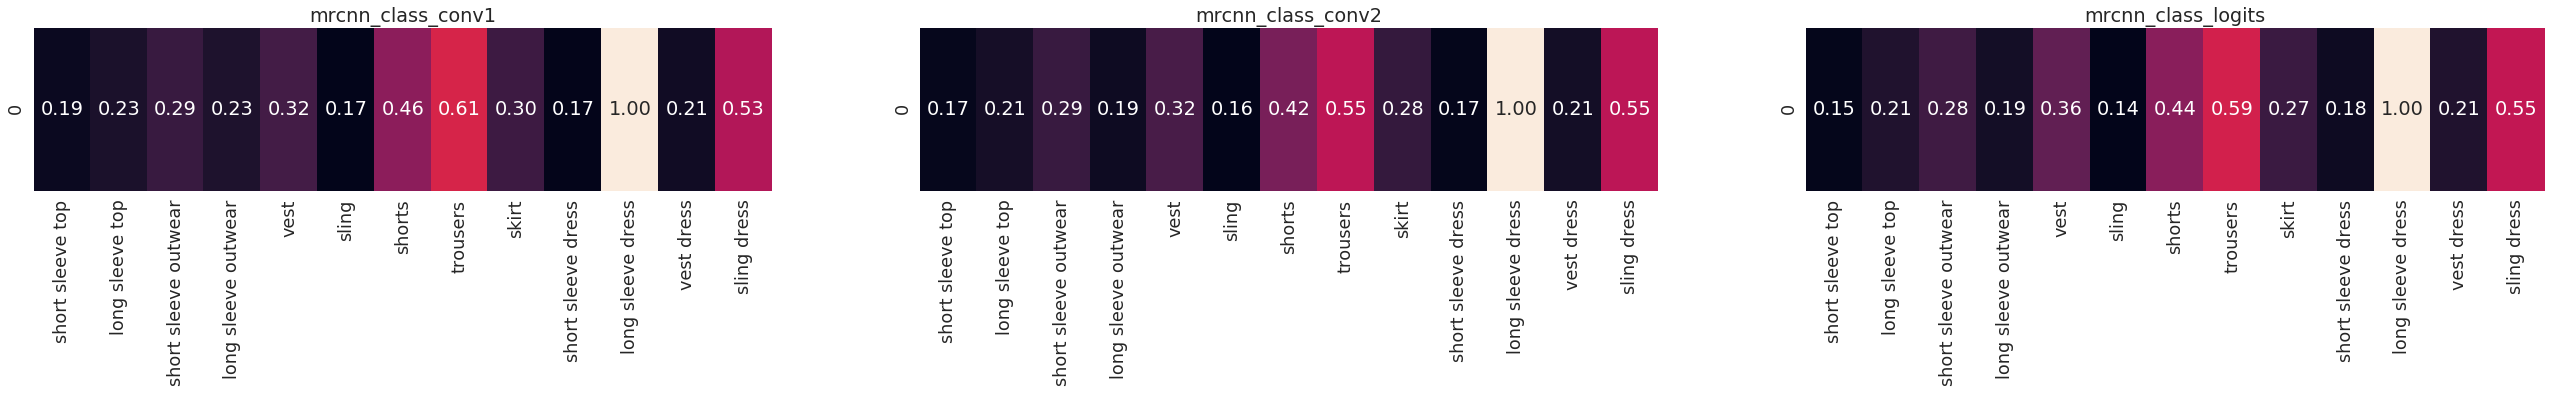

In [146]:

#Visualize it
x = [info['name'] for info in dataset.class_info if info['name'] != 'BG']

# create an index for each tick position
xi = list(range(len(x)))

fig, axs = plt.subplots(1, 3, figsize=(3*15, 3))

for i in range(1, len(layer_names)+1):
    ax = axs[i-1]
    ax.set_title(layer_names[i-1])
    df = pd.DataFrame(data=differences_same[i-1])
    df.columns = x
    sns.heatmap(df, annot=True, ax = ax, fmt='.2f', cbar=False)
    
plt.tight_layout()
plt.show()

## Calculate Mask Average Precison (mAP)

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
import time
sample_size = 1

image_ids = np.random.choice(dataset_val.image_ids, sample_size)
APs = []

item = 0
start = time.time()
print("Calculating mAP on {} items".format(sample_size))
for image_id in image_ids:
    if(item % 10 == 0):
        end = time.time()
        print("{} percent done".format(100*item/sample_size))
        print("{} seconds per item".format((end-start)/10))
        start = time.time()
    item = item+1
    #Load image and ground truth data
    image_org, image_meta, gt_class_id, gt_bbox, gt_mask, gt_landmark =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

    molded_images = np.expand_dims(modellib.mold_image(image_org, inference_config), 0)
    # Run object detection
    results = model.detect([image_org], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

Calculating mAP on 1 items
0.0 percent done
7.610321044921875e-05 seconds per item
mAP:  0.0


## Compare Class Accuracy
### Setup data tables

In [249]:
data = pd.read_csv('val_class_predictions.csv')
preds = data.drop(columns={'Unnamed: 0'})

data = pd.read_csv('val_gt.csv')
truth = data.drop(columns={'Unnamed: 0'})

#Convert the string representation of lists into actual lists
truth['as_list'] = truth.apply(lambda x: ast.literal_eval(x['gt']),axis=1)

#Add the number of clothes in each image for convenience 
truth['gt_item_count'] = truth.apply(lambda x: len(x['as_list']),axis=1)

#Join the lists
table = preds.join(truth)

#Check it
table.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,gt,as_list,gt_item_count
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,[12],[12],1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.611961,0.000000,0.0,0.0,0.0,[12],[12],1
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.671467,0.0,0.0,0.0,[10],[10],1
3,0.0,0.997592,0.0,0.0,0.0,0.0,0.0,0.0,0.70817,0.000000,0.000000,0.0,0.0,0.0,"[8, 1]","[8, 1]",2
4,0.0,0.900597,0.0,0.0,0.0,0.0,0.0,0.0,0.99964,0.000000,0.000000,0.0,0.0,0.0,"[8, 2]","[8, 2]",2


### Quick calculate mAP over the entire val_set

In [281]:
# Remove unneeded cols
mAP_table = table.drop(columns=['gt', 'gt_item_count'])

total_amount_of_articles = 0
correctly_detected_articles = 0
total_amount_of_detected_articles = 0

for i in range(len(mAP_table)):
    # Get the results for each image/row in the table
    row = mAP_table.iloc[[i]]
    
    # Count amount of detected items (the -1 is for the gt column)
    total_amount_of_detected_articles += row.astype(bool).sum(axis=1).values[0] - 1
    
    # Extract all the clothing articles present in gt
    articles = row['as_list'].values[0]
    
    for article in articles:
        # Increment the amount of articles we've tried to detect
        total_amount_of_articles += 1
        
        
        # Check if we have detected the article
        class_confidence = row[str(article)].values[0]
        
        if class_confidence > 0:
             #If so increment correctly detected articles
            correctly_detected_articles += 1

print("mAP = {}".format(correctly_detected_articles/total_amount_of_detected_articles))

mAP = 0.5786229568075975


### Single item detection
Some statistics when there is only one article of clothing in the image to detect, for simplicitys sake

In [21]:
# Get single-item images
single = table[table['gt_item_count'] == 1]

#Pick the items from the list, otherwise we can't use groupby
single['gt'] = single.apply(lambda x: x['as_list'][0],axis=1)

/home/vic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
# For each type of cloth, check what the network believes it to be on average
average_confidence = single.groupby('gt').mean().drop(columns = {'gt_item_count'})

#Use names instead of numbers for predictions
average_confidence.columns = dataset_val.class_names

#The BG column is useless
average_confidence = average_confidence.drop(columns="BG")

#Use names instead of numbers for gt_classes
average_confidence.index = average_confidence.columns.values

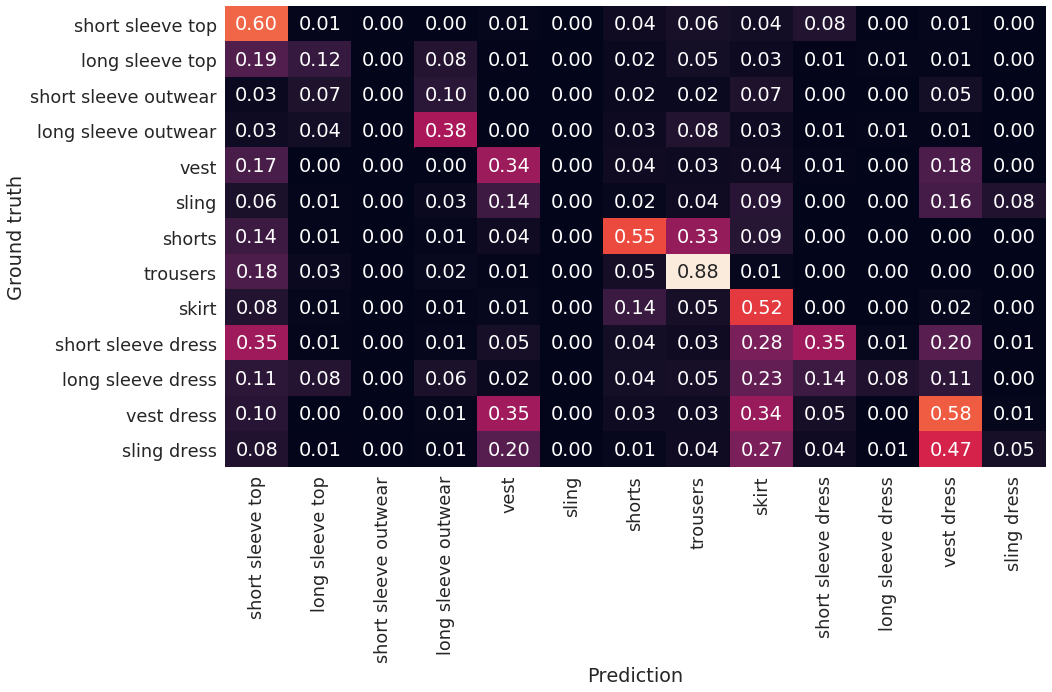

In [153]:
#Visualize it
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(average_confidence, annot=True, ax = ax, fmt='.2f', cbar=False)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground truth')
ax.labelsize = 'small'
plt.tight_layout()
plt.show()

Number of items in each class


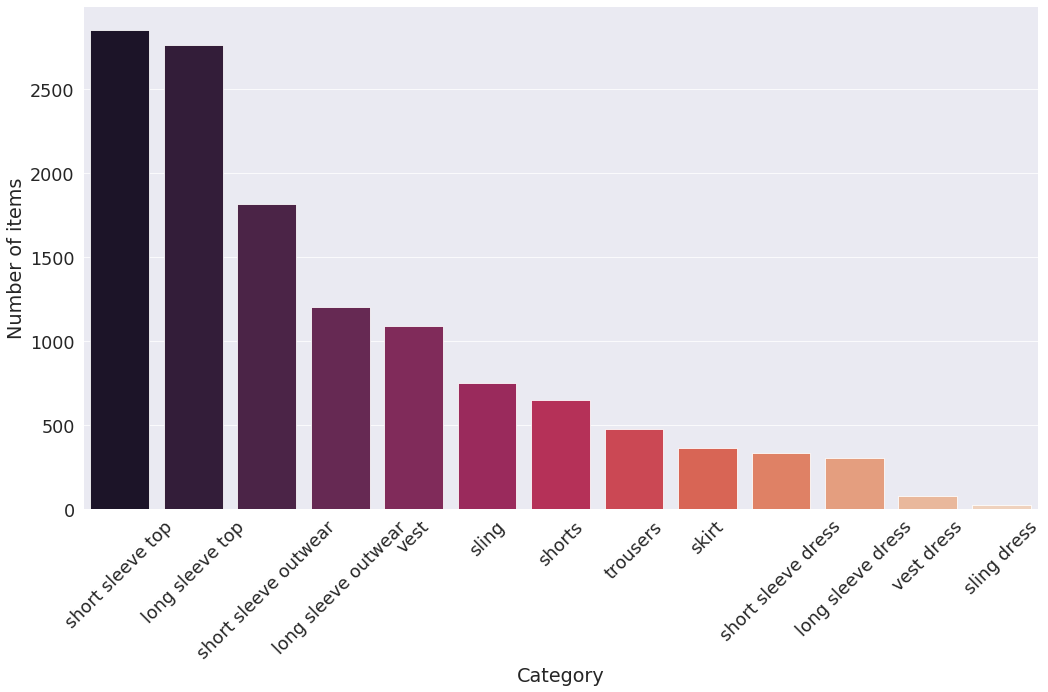

In [154]:
print("Number of items in each class")
sns.set_context("paper",font_scale=2)
fix, ax = plt.subplots(figsize = (15,10))
counts = single.groupby('gt').count()[['gt_item_count']]
counts = counts.sort_values(by='gt_item_count', ascending=False)
counts.index = average_confidence.columns.values

sns.barplot(x=counts.index, y = counts.gt_item_count, palette="rocket")
plt.xticks(rotation=45)
ax.set_xlabel('Category')
ax.set_ylabel('Number of items')
plt.tight_layout()
plt.show()

### Quick calculate mAP over all single-item images

In [284]:
# Remove unneeded cols
mAP_table = single.drop(columns=['gt', 'gt_item_count'])

total_amount_of_articles = 0
correctly_detected_articles = 0
total_amount_of_detected_articles = 0

for i in range(len(mAP_table)):
    # Get the results for each image/row in the table
    row = mAP_table.iloc[[i]]
    
    # Count amount of detected items (the -1 is for the gt column)
    total_amount_of_detected_articles += row.astype(bool).sum(axis=1).values[0] - 1
    
    # Extract all the clothing articles present in gt
    articles = row['as_list'].values[0]
    
    for article in articles:
        # Increment the amount of articles we've tried to detect
        total_amount_of_articles += 1
        
        
        # Check if we have detected the article
        class_confidence = row[str(article)].values[0]
        
        if class_confidence > 0:
             #If so increment correctly detected articles
            correctly_detected_articles += 1

print("mAP = {}".format(correctly_detected_articles/total_amount_of_detected_articles))

mAP = 0.36036801840092003
